In [1]:
import os

# Define the dataset directories
datasets_dir = os.path.join(os.path.expanduser('~'), 'datasets')
dataset_dir = os.path.join(datasets_dir, 'people_detect')

# Model target directory
model_dir = os.path.expanduser('~/models/people_detect')

# Define the size of the input images. In the case of an
# MLX90640 it will be (24, 32) for horizontal images and
# (32, 24) for vertical images
image_size = (32, 24)

# Image generator batch size
batch_size = 64

# Number of training epochs
epochs = 5

In [2]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_data = generator.flow_from_directory(dataset_dir,
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           subset='training',
                                           class_mode='categorical',
                                           color_mode='grayscale')

test_data = generator.flow_from_directory(dataset_dir,
                                          target_size=image_size,
                                          batch_size=batch_size,
                                          subset='validation',
                                          class_mode='categorical',
                                          color_mode='grayscale')

Using TensorFlow backend.


Found 1406 images belonging to 2 classes.
Found 602 images belonging to 2 classes.


In [3]:
index_to_label = {
    index: label
    for label, index in train_data.class_indices.items()
}

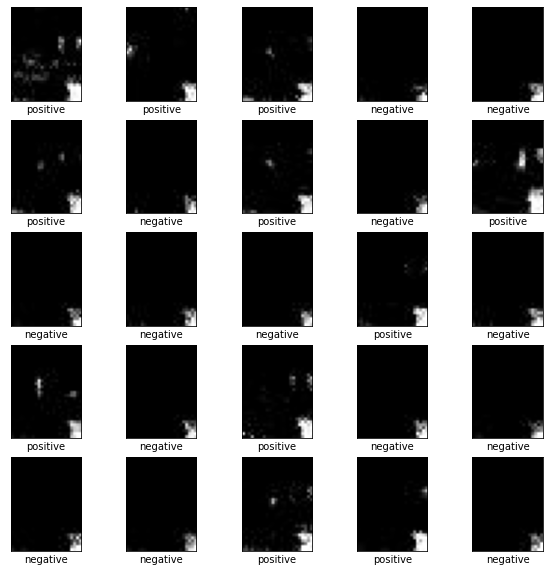

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
batch = train_data.next()

for i in range(min(25, len(batch[0]))):
    img = batch[0][i]
    label = index_to_label[np.argmax(batch[1][i])]
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(img))
    plt.xlabel(label)

plt.show()
# plt.savefig('/home/blacklight/ir-dataset-1.png')

In [54]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Flatten(input_shape=image_size),
    keras.layers.Dense(round(0.8 * image_size[0] * image_size[1]), activation=tf.nn.relu),
    keras.layers.Dense(round(0.3 * image_size[0] * image_size[1]), activation=tf.nn.relu),
    keras.layers.Dense(len(train_data.class_indices), activation=tf.nn.softmax)
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [55]:
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples/batch_size,
    validation_data=test_data,
    validation_steps=test_data.samples/batch_size,
    epochs=epochs
)

Epoch 1/5
22/21 [==============================] - 1s 28ms/step - loss: 0.2853 - accuracy: 0.8713 - val_loss: 0.1160 - val_accuracy: 0.9784
Epoch 2/5
22/21 [==============================] - 0s 22ms/step - loss: 0.0747 - accuracy: 0.9751 - val_loss: 0.0170 - val_accuracy: 0.9934
Epoch 3/5
22/21 [==============================] - 1s 39ms/step - loss: 0.0279 - accuracy: 0.9900 - val_loss: 0.0159 - val_accuracy: 0.9983

In [17]:
model.evaluate(test_data, batch_size=batch_size, steps=test_data.samples/batch_size)

10/9 [===============================] - 0s 12ms/step - loss: 0.0047 - accuracy: 0.9983


[0.004685928579419851, 0.9983388781547546]

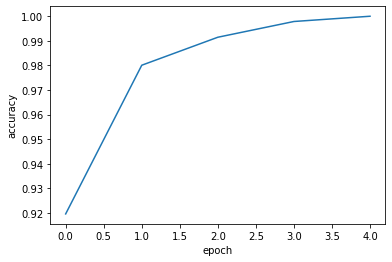

In [19]:
epochs = history.epoch
accuracy = history.history['accuracy']

fig = plt.figure()
plot = fig.add_subplot()
plot.set_xlabel('epoch')
plot.set_ylabel('accuracy')
plot.plot(epochs, accuracy)
# plt.savefig('/home/blacklight/ir-dataset-accuracy.png')

In [18]:
import matplotlib.pyplot as plt

def plot_image_and_predictions(prediction, classes, true_label, img):
    import numpy as np
    import matplotlib.pyplot as plt

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.squeeze(img))
    predicted_label = int(np.argmax(prediction))
    confidence = 100 * np.max(prediction)
    color = 'blue' if predicted_label == true_label else 'red'

    plt.xlabel('{predicted} {confidence:2.0f}% ({expected})'.format(
        predicted=classes[predicted_label],
        confidence=confidence,
        expected=classes[int(true_label)]), color=color)

def plot_value_array(prediction, true_label):
    import numpy as np
    import matplotlib.pyplot as plt

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(len(prediction)), prediction, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(prediction)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
def plot_results(images, labels, predictions, classes, rows, cols):
    n_images = rows * cols
    plt.figure(figsize=(2 * 2 * cols, 2 * rows))

    for i in range(n_images):
        plt.subplot(rows, 2 * cols, 2 * i + 1)
        plot_image_and_predictions(predictions[i], classes, labels[i], images[i])
        plt.subplot(rows, 2 * cols, 2 * i + 2)
        plot_value_array(predictions[i], labels[i])

    plt.savefig('/home/blacklight/ir-detect-evaluation.png')
    plt.show()

In [9]:
test_batch = test_data.next()
test_images = test_batch[0]
test_labels = test_batch[1]
predictions = model.predict(test_images)

In [20]:
import numpy as np
test_img = test_images[0]
expected_label = index_to_label[np.argmax(test_labels[0])]
prediction = model.predict(np.asarray([test_img]))
predicted_label = index_to_label[np.argmax(prediction)]
print(f'Expected label: {expected_label}. Predicted label: {predicted_label}')

Expected label: negative. Predicted label: negative


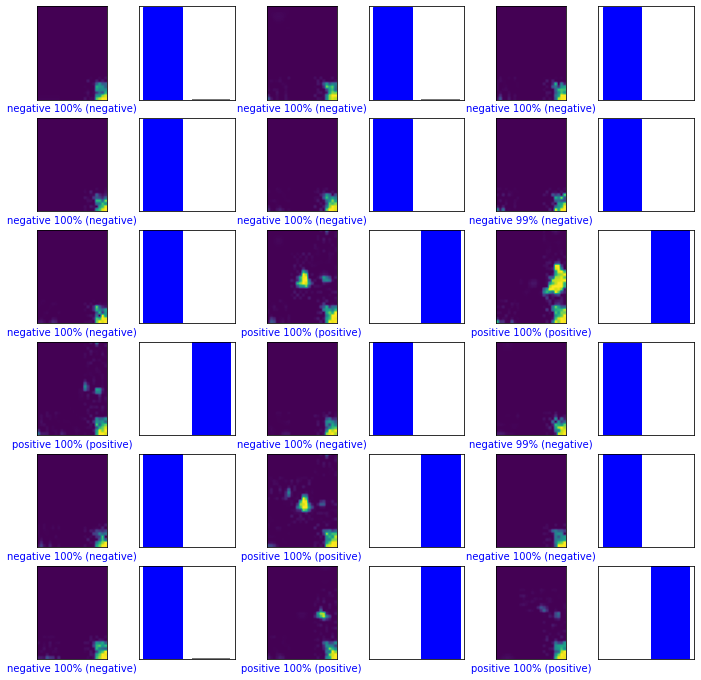

In [19]:
plot_results(
    images=test_images,
    labels=[np.argmax(label_values) for label_values in test_labels],
    classes=index_to_label,
    predictions=predictions,
    rows=6, cols=3)

In [9]:
def model_save(model, target, labels=None, overwrite=True):
    import json
    import pathlib

    # Check if we should save it like a .h5 file or
    # as a directory
    model_dir = pathlib.Path(target)
    if str(target).endswith('.h5') or str(target).endswith('.pb'):
        model_dir = model_dir.parent

    # Create the model directory if it doesn't exist
    pathlib.Path(model_dir).mkdir(parents=True, exist_ok=True)

    # Save the TensorFlow model using the save primitive
    model.save(target, overwrite=overwrite)

    # Save the label names of your model in a separate JSON file
    if labels:
        labels_file = os.path.join(model_dir, 'labels.json')
        with open(labels_file, 'w') as f:
            f.write(json.dumps(list(labels)))

INFO:tensorflow:Assets written to: /home/blacklight/models/people_detect.pb/assets


In [ ]:
# model_save(model, model_dir, train_data.class_indices.keys(), overwrite=True)
# model_save(model, '/home/blacklight/models/people_detect.h5', train_data.class_indices.keys(), overwrite=True)
model_save(model, '/home/blacklight/models/people_detect.pb', train_data.class_indices.keys(), overwrite=True)

In [5]:
def model_load(source, labels_file=None):
    import json
    import os
    from tensorflow.keras.models import load_model

    labels = []
    if not labels_file:
        if os.path.isdir(source):
            labels_file = os.path.join(source, 'labels.json')
        else:
            labels_file = os.path.join(os.path.dirname(source), 'labels.json')

    if os.path.isfile(labels_file):
        with open(labels_file) as f:
            labels = json.load(f)

    m = load_model(source)
    return m, labels

In [6]:
model, labels = model_load(model_dir)
